# 🚀 SpaceX First-Stage Landing Prediction — Capstone (Alishba)

**Goal:** Build a full data science pipeline to predict whether the **Falcon 9 first stage lands successfully**, enabling cost estimation for launches (~$62M vs. ~$165M+).

**Deliverables:**  
- A reproducible Colab Notebook covering: Data Collection → Wrangling → EDA → SQL → Interactive Visuals (Folium, Plotly) → Modeling → Evaluation.  
- A final report summarizing findings and recommendations.

**You will run this notebook in Google Colab.**  
This file was generated on **2025-08-21 09:01 UTC**.


## ✅ Project Checklist
- [ ] Data Collection (SpaceX API + Wikipedia)
- [ ] Data Wrangling (cleaning, OHE, target)
- [ ] EDA (static + interactive)
- [ ] SQL Insights (ipython-sql)
- [ ] Folium Maps (launch sites + outcomes)
- [ ] Plotly Dash (interactive dashboard)
- [ ] Modeling (LR, DT, RF, SVM) + tuning
- [ ] Evaluation (Accuracy, Precision, Recall, F1)
- [ ] Final Results & Export

---

 Environment Setup


In [2]:
#@title Install dependencies (safe to re-run)

!pip -q install requests pandas numpy beautifulsoup4 lxml matplotlib seaborn plotly folium scikit-learn   sqlalchemy ipython-sql jupyter-dash dash==2.16.1 dash-bootstrap-components==1.6.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00


0.1) Imports & Utilities

In [3]:
import os
import sys
import json
import time
import math
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import requests
from bs4 import BeautifulSoup

In [4]:
# SQL magics
%load_ext sql

# Global display and randomness control
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Output paths
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

RAW_API_CSV = os.path.join(DATA_DIR, 'spacex_launch_data_raw.csv')
RAW_WIKI_CSV = os.path.join(DATA_DIR, 'wikipedia_launches_raw.csv')

print('Folders ready:', os.path.abspath(DATA_DIR))

Folders ready: /content/data


---
# 1) Data Collection

We collect data from two sources:

1. **SpaceX REST API (v4)** — canonical structured launch data.  
2. **Wikipedia** — supplemental tables for payloads, orbits, etc., as a cross-check.

We'll save raw CSVs in a local `data/` folder for reproducibility.


### 1.1) SpaceX REST API — fetch & assemble master table

**Endpoints used (v4):**
- `/v4/launches` — launch-level data (date, success, payload/rocket IDs, cores list)
- `/v4/rockets` — rocket names/specs
- `/v4/payloads` — payload mass & orbits
- `/v4/launchpads` — launchpad names & geo
- `/v4/cores` — core reuse info (flights, reuse count)

We'll hydrate IDs into human-readable columns and engineer the **target**: `first_stage_landing_success` from the first core's `landing_success` field.

In [5]:
# Helper to download a SpaceX v4 endpoint safely
def spacex_get(path):
    base = "https://api.spacexdata.com/v4"
    url = f"{base}/{path.strip('/')}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.json()

# Fetch raw entities
launches = spacex_get("launches")
rockets = spacex_get("rockets")
payloads = spacex_get("payloads")
launchpads = spacex_get("launchpads")
cores = spacex_get("cores")

print(f"Fetched: launches={len(launches)}, rockets={len(rockets)}, payloads={len(payloads)}, launchpads={len(launchpads)}, cores={len(cores)}")

# Build lookup dictionaries
rocket_lookup = {r['id']: r.get('name') for r in rockets}
launchpad_lookup = {p['id']: p.get('name') or p.get('full_name') for p in launchpads}
launchpad_full_lookup = {p['id']: p.get('full_name') for p in launchpads}
payload_lookup = {p['id']: p for p in payloads}
core_lookup = {c['id']: c for c in cores}
rows = []
for L in launches:
    # Basic fields
    flight_number = L.get('flight_number')
    name = L.get('name')
    date_utc = L.get('date_utc')
    date = pd.to_datetime(date_utc, errors='coerce')
    year = date.year if pd.notnull(date) else None
    tbd = L.get('tbd')
    success = L.get('success')
    details = L.get('details')

    rocket_id = L.get('rocket')
    rocket_name = rocket_lookup.get(rocket_id, None)

    launchpad_id = L.get('launchpad')
    launch_site_name = launchpad_lookup.get(launchpad_id, None)
    launch_site_full = launchpad_full_lookup.get(launchpad_id, None)

    payload_ids = L.get('payloads') or []
    payload_masses = []
    payload_orbits = []
    payload_types = []
    for pid in payload_ids:
        p = payload_lookup.get(pid, {})
        mass = p.get('mass_kg')
        if mass is not None:
            payload_masses.append(mass)
        orbit = p.get('orbit')
        if orbit is not None:
            payload_orbits.append(orbit)
        ptype = p.get('type')
        if ptype is not None:
            payload_types.append(ptype)

    # Aggregate payload info
    payload_mass_kg_mean = float(np.mean(payload_masses)) if payload_masses else None
    payload_mass_kg_sum = float(np.sum(payload_masses)) if payload_masses else None
    primary_orbit = payload_orbits[0] if payload_orbits else None
    primary_payload_type = payload_types[0] if payload_types else None
    # Cores info (first stage)
    cores_list = L.get('cores') or []
    first_stage = cores_list[0] if len(cores_list) > 0 else {}
    landing_attempt = first_stage.get('landing_attempt')
    landing_success = first_stage.get('landing_success')
    landing_type = first_stage.get('landing_type')
    landpad = first_stage.get('landpad')
    core_id = first_stage.get('core')

    # Core reuse / flights
    core_flights = first_stage.get('flight')
    core_reused = first_stage.get('reused')
    # Enrich with core entity (total lifetime flights if available)
    core_total_flights = None
    if core_id and core_id in core_lookup:
        core_total_flights = core_lookup[core_id].get('flights')

    rows.append({
        'flight_number': flight_number,
        'mission_name': name,
        'date_utc': date_utc,
        'year': year,
        'rocket_id': rocket_id,
        'rocket_name': rocket_name,
        'launchpad_id': launchpad_id,
        'launch_site_name': launch_site_name,
        'launch_site_full': launch_site_full,
        'success_launch': success,
        'payload_count': len(payload_ids),
        'payload_mass_kg_mean': payload_mass_kg_mean,
        'payload_mass_kg_sum': payload_mass_kg_sum,
        'primary_orbit': primary_orbit,
        'primary_payload_type': primary_payload_type,
        'landing_attempt': landing_attempt,
        'first_stage_landing_success': landing_success,
        'landing_type': landing_type,
        'landpad': landpad,
        'core_id': core_id,
        'core_flights_on_this_mission': core_flights,
        'core_reused_on_this_mission': core_reused,
        'core_total_flights_lifetime': core_total_flights,
        'details': details
    })

api_df = pd.DataFrame(rows).sort_values(['year','flight_number']).reset_index(drop=True)
api_df.to_csv(RAW_API_CSV, index=False)
print('API dataframe shape:', api_df.shape, '| Saved ->', RAW_API_CSV)
api_df.head(10)

Fetched: launches=205, rockets=4, payloads=225, launchpads=6, cores=83
API dataframe shape: (205, 24) | Saved -> data/spacex_launch_data_raw.csv


,flight_number,mission_name,date_utc,year,rocket_id,rocket_name,launchpad_id,launch_site_name,launch_site_full,success_launch,payload_count,payload_mass_kg_mean,payload_mass_kg_sum,primary_orbit,primary_payload_type,landing_attempt,first_stage_landing_success,landing_type,landpad,core_id,core_flights_on_this_mission,core_reused_on_this_mission,core_total_flights_lifetime,details
0,1,FalconSat,2006-03-24T22:30:00.000Z,2006,5e9d0d95eda69955f709d1eb,Falcon 1,5e9e4502f5090995de566f86,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,1,20.0,20.0,LEO,Satellite,False,None,None,None,5e9e289df35918033d3b2623,1.0,False,None,Engine failure at 33 seconds and loss of vehicle
1,2,DemoSat,2007-03-21T01:10:00.000Z,2007,5e9d0d95eda69955f709d1eb,Falcon 1,5e9e4502f5090995de566f86,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,1,NaN,NaN,LEO,Satellite,False,None,None,None,5e9e289ef35918416a3b2624,1.0,False,None,Successful first stage burn and transition to ...
2,3,Trailblazer,2008-08-03T03:34:00.000Z,2008,5e9d0d95eda69955f709d1eb,Falcon 1,5e9e4502f5090995de566f86,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,2,NaN,NaN,LEO,Satellite,False,None,None,None,5e9e289ef3591814873b2625,1.0,False,None,Residual stage 1 thrust led to collision betwe...
3,4,RatSat,2008-09-28T23:15:00.000Z,2008,5e9d0d95eda69955f709d1eb,Falcon 1,5e9e4502f5090995de566f86,Kwajalein Atoll,Kwajalein Atoll Omelek Island,True,1,165.0,165.0,LEO,Satellite,False,None,None,None,5e9e289ef3591855dc3b2626,1.0,False,None,Ratsat was carried to orbit on the first succe...
4,5,RazakSat,2009-07-13T03:35:00.000Z,2009,5e9d0d95eda69955f709d1eb,Falcon 1,5e9e4502f5090995de566f86,Kwajalein Atoll,Kwajalein Atoll Omelek Island,True,1,200.0,200.0,LEO,Satellite,False,None,None,None,5e9e289ef359184f103b2627,1.0,False,None,None
5,6,Falcon 9 Test Flight,2010-06-04T18:45:00.000Z,2010,5e9d0d95eda69973a809d1ec,Falcon 9,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral Space Force Station Space Launc...,True,1,NaN,NaN,LEO,Dragon Boilerplate,False,None,None,None,5e9e289ef359185f2b3b2628,1.0,False,None,None
6,7,COTS 1,2010-12-08T15:43:00.000Z,2010,5e9d0d95eda69973a809d1ec,Falcon 9,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral Space Force Station Space Launc...,True,2,NaN,NaN,LEO,Dragon 1.0,False,None,None,None,5e9e289ef35918187c3b2629,1.0,False,None,None
7,8,COTS 2,2012-05-22T07:44:00.000Z,2012,5e9d0d95eda69973a809d1ec,Falcon 9,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral Space Force Station Space Launc...,True,1,525.0,525.0,LEO,Dragon 1.0,False,None,None,None,5e9e289ef35918f39c3b262a,1.0,False,None,"Launch was scrubbed on first attempt, second l..."
8,9,CRS-1,2012-10-08T00:35:00.000Z,2012,5e9d0d95eda69973a809d1ec,Falcon 9,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral Space Force Station Space Launc...,True,2,400.0,800.0,ISS,Dragon 1.0,False,None,None,None,5e9e289ff3591821a73b262b,1.0,False,None,"CRS-1 successful, but the secondary payload wa..."
9,10,CRS-2,2013-03-01T19:10:00.000Z,2013,5e9d0d95eda69973a809d1ec,Falcon 9,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral Space Force Station Space Launc...,True,1,677.0,677.0,ISS,Dragon 1.0,False,None,None,None,5e9e289ff3591884e03b262c,1.0,False,None,Last launch of the original Falcon 9 v1.0 laun...


### 1.2) Wikipedia — supplemental launch tables

We'll scrape **Wikipedia: List of Falcon 9 and Falcon Heavy launches** for cross-checking payload/orbit details.
> Note: Wikipedia tables change over time. This code tries to be resilient but may need minor adjustment if the structure is altered.


In [6]:
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"

tables = pd.read_html(WIKI_URL, flavor='lxml')
print(f"Found {len(tables)} tables on the page.")

# Heuristic: Keep tables that look like mission logs (have columns like 'Flight', 'Date', 'Payload', 'Orbit')
candidate_tables = []
for t in tables:
    cols = [str(c).lower() for c in t.columns]
    if any('flight' in c for c in cols) and any('date' in c for c in cols):
        candidate_tables.append(t)

print(f"Candidate mission tables: {len(candidate_tables)}")

def clean_wiki_table(df):
    # Standardize column names
    df = df.copy()
    df.columns = [str(c).strip().lower().replace('\n',' ').replace('  ',' ') for c in df.columns]
    # Keep useful columns if they exist
    keep_cols = ['flight', 'date', 'payload', 'payload mass', 'orbit', 'launch site', 'booster', 'landing']
    existing = [c for c in df.columns if any(k in c for k in keep_cols)]
    df = df[existing]
    # Remove multiindex if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join([str(x) for x in tup if x]) for tup in df.columns]
    # Basic cleaning
    for c in df.columns:
        df[c] = df[c].astype(str).str.replace('\[.*?\]','', regex=True).str.strip()
    return df

cleaned = [clean_wiki_table(t) for t in candidate_tables if len(t) > 0]
wiki_df = pd.concat(cleaned, ignore_index=True).dropna(how='all')
wiki_df = wiki_df.loc[:,~wiki_df.columns.duplicated()].copy()


#-----------------------------
# Wikipedia payload mass cleaning (robust)
# -----------------------------

# Find any column that looks like payload mass
mass_cols = [c for c in wiki_df.columns if 'mass' in c.lower()]

print("Detected mass columns:", mass_cols)

# -----------------------------
# Wikipedia payload mass cleaning (fixed)
# -----------------------------

# Find any column that looks like payload mass
mass_cols = [c for c in wiki_df.columns if 'mass' in c.lower()]
print("Detected mass columns:", mass_cols)

for c in mass_cols:
    # Extract number and optional unit (kg, t, tonne, tons)
    extracted = wiki_df[c].astype(str).str.replace(',', '', regex=False).str.extract(r'([\d\.]+)\s*(kg|t|tonne|tons)?')

    num = pd.to_numeric(extracted[0], errors='coerce')   # numeric part
    unit = extracted[1].str.lower()                      # unit part

    # Convert all to kg
    wiki_df[c + '_kg_final'] = np.where(unit.isin(['t','tonne','tons']), num * 1000, num)

# Pick the first matching column and standardize
if mass_cols:
    wiki_df['payload_mass_kg_extracted'] = wiki_df[mass_cols[0] + '_kg_final']

# Parse date if present
if 'date' in wiki_df.columns:
    wiki_df['date_parsed'] = pd.to_datetime(wiki_df['date'], errors='coerce')
    wiki_df['year'] = wiki_df['date_parsed'].dt.year

# Save cleaned wiki data
wiki_df.to_csv(RAW_WIKI_CSV, index=False)
print('Wikipedia dataframe shape:', wiki_df.shape, '| Saved ->', RAW_WIKI_CSV)

wiki_df.head(10)


<>:28: SyntaxWarning: invalid escape sequence '\['
<>:28: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-3532012224.py:28: SyntaxWarning: invalid escape sequence '\['
  df[c] = df[c].astype(str).str.replace('\[.*?\]','', regex=True).str.strip()


Found 16 tables on the page.
Candidate mission tables: 2
Detected mass columns: ['payload mass']
Detected mass columns: ['payload mass']
Wikipedia dataframe shape: (477, 10) | Saved -> data/wikipedia_launches_raw.csv


,flight no.,date and time (utc),"version, booster[i]",launch site,payload[j],payload mass,orbit,booster landing,payload mass_kg_final,payload_mass_kg_extracted
0,286,"January 3, 2024 03:44",F9 B5 B1082‑1,"Vandenberg, SLC‑4E",Starlink: Group 7-9 (22 satellites),"~16,800 kg (37,000 lb)",LEO,Success (OCISLY),16800.0,16800.0
1,286,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...",22.0,22.0
2,287,"January 3, 2024 23:04",F9 B5 B1076‑10,"Cape Canaveral, SLC‑40",Ovzon-3,"1,800 kg (4,000 lb)",GTO,Success (LZ‑1),1800.0,1800.0
3,287,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,NaN,NaN
4,288,"January 7, 2024 22:35",F9 B5 B1067‑16,"Cape Canaveral, SLC‑40",Starlink: Group 6-35 (23 satellites),"~17,100 kg (37,700 lb)",LEO,Success (ASOG),17100.0,17100.0
5,288,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,23.0,23.0
6,289,"January 14, 2024 08:59",F9 B5 B1061‑18,"Vandenberg, SLC‑4E",Starlink: Group 7-10 (22 satellites),"~16,700 kg (36,800 lb)",LEO,Success (OCISLY),16700.0,16700.0
7,289,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,Launch of 22 Starlink v2 mini satellites to a ...,22.0,22.0
8,290,"January 15, 2024 01:52",F9 B5 B1073‑12,"Cape Canaveral, SLC‑40",Starlink: Group 6-37 (23 satellites),"~17,100 kg (37,700 lb)",LEO,Success (ASOG),17100.0,17100.0
9,290,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,23.0,23.0


In [53]:
# -----------------------------
# 2) DATA WRANGLING
# -----------------------------

# Reload saved data (ensures reproducibility if notebook restarted)
api_df = pd.read_csv(RAW_API_CSV)
wiki_df = pd.read_csv(RAW_WIKI_CSV)

print("API DF:", api_df.shape, " | WIKI DF:", wiki_df.shape)

# -----------------------------
# 2.1) Focus only on useful columns
# -----------------------------
keep_cols = [
    'flight_number','mission_name','year','rocket_name','launch_site_name',
    'success_launch','payload_mass_kg_mean','payload_mass_kg_sum',
    'primary_orbit','landing_attempt','first_stage_landing_success',
    'landing_type','core_flights_on_this_mission','core_total_flights_lifetime'
]

df = api_df[keep_cols].copy()

# -----------------------------
# 2.2) Handle missing values
# -----------------------------
print("Missingness before cleaning:\n", df.isna().mean().sort_values(ascending=False))

# Strategy:
# - Payload mass: fill NaNs with 0
# - Orbits: fill NaNs with 'Unknown'
# - Core flights: fill with 0
# - Target: drop rows with missing landing success (cannot train without labels)

df['payload_mass_kg_mean'] = df['payload_mass_kg_mean'].fillna(0)
df['payload_mass_kg_sum'] = df['payload_mass_kg_sum'].fillna(0)
df['primary_orbit'] = df['primary_orbit'].fillna('Unknown')
df['core_flights_on_this_mission'] = df['core_flights_on_this_mission'].fillna(0)
df['core_total_flights_lifetime'] = df['core_total_flights_lifetime'].fillna(0)

df = df.dropna(subset=['first_stage_landing_success'])  # keep only labeled

# Convert boolean target to int
df['first_stage_landing_success'] = df['first_stage_landing_success'].astype(int)

print("Cleaned shape:", df.shape)

# -----------------------------
# 2.3) Encode Categorical Variables
# -----------------------------
cat_features = ['rocket_name','launch_site_name','primary_orbit','landing_type']
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

print("Encoded shape:", df_encoded.shape)

# -----------------------------
# 2.4) Save Cleaned Data
# -----------------------------
CLEAN_CSV = os.path.join(DATA_DIR, "spacex_clean.csv")
df_encoded.to_csv(CLEAN_CSV, index=False)
print("✅ Clean dataset saved ->", CLEAN_CSV)

df_encoded.head()


API DF: (205, 24)  | WIKI DF: (477, 10)
Missingness before cleaning:
 core_total_flights_lifetime     1.000000
first_stage_landing_success     0.239024
landing_type                    0.229268
payload_mass_kg_mean            0.190244
payload_mass_kg_sum             0.190244
success_launch                  0.092683
landing_attempt                 0.087805
core_flights_on_this_mission    0.082927
primary_orbit                   0.063415
launch_site_name                0.000000
flight_number                   0.000000
rocket_name                     0.000000
year                            0.000000
mission_name                    0.000000
dtype: float64
Cleaned shape: (156, 14)
Encoded shape: (156, 27)
✅ Clean dataset saved -> data/spacex_clean.csv


,flight_number,mission_name,year,success_launch,payload_mass_kg_mean,payload_mass_kg_sum,landing_attempt,first_stage_landing_success,core_flights_on_this_mission,core_total_flights_lifetime,rocket_name_Falcon Heavy,launch_site_name_KSC LC 39A,launch_site_name_VAFB SLC 4E,primary_orbit_GEO,primary_orbit_GTO,primary_orbit_HCO,primary_orbit_HEO,primary_orbit_ISS,primary_orbit_LEO,primary_orbit_MEO,primary_orbit_PO,primary_orbit_SSO,primary_orbit_TLI,primary_orbit_Unknown,primary_orbit_VLEO,landing_type_Ocean,landing_type_RTLS
10,11,CASSIOPE,2013,True,500.0,500.0,True,0,1.0,0.0,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False
13,14,CRS-3,2014,True,2296.0,2296.0,True,1,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
14,15,OG-2 Mission 1,2014,True,1316.0,1316.0,True,1,1.0,0.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
17,18,CRS-4,2014,True,2216.0,2216.0,True,0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
18,19,CRS-5,2015,True,2395.0,2395.0,True,0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


Step 3: Exploratory Data Analysis (EDA)

Now we’ll start exploring patterns in the cleaned dataset.

(a) Load cleaned dataset

In [8]:
import pandas as pd

df = pd.read_csv(RAW_WIKI_CSV)
print("Data shape:", df.shape)
df.head()


Data shape: (477, 10)


,flight no.,date and time (utc),"version, booster[i]",launch site,payload[j],payload mass,orbit,booster landing,payload mass_kg_final,payload_mass_kg_extracted
0,286,"January 3, 2024 03:44",F9 B5 B1082‑1,"Vandenberg, SLC‑4E",Starlink: Group 7-9 (22 satellites),"~16,800 kg (37,000 lb)",LEO,Success (OCISLY),16800.0,16800.0
1,286,"Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...","Launch of 22 Starlink v2 mini satellites, incl...",22.0,22.0
2,287,"January 3, 2024 23:04",F9 B5 B1076‑10,"Cape Canaveral, SLC‑40",Ovzon-3,"1,800 kg (4,000 lb)",GTO,Success (LZ‑1),1800.0,1800.0
3,287,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,Broadband internet provider satellite. First F...,NaN,NaN
4,288,"January 7, 2024 22:35",F9 B5 B1067‑16,"Cape Canaveral, SLC‑40",Starlink: Group 6-35 (23 satellites),"~17,100 kg (37,700 lb)",LEO,Success (ASOG),17100.0,17100.0


In [9]:
df.describe(include = 'all')

,flight no.,date and time (utc),"version, booster[i]",launch site,payload[j],payload mass,orbit,booster landing,payload mass_kg_final,payload_mass_kg_extracted
count,477,477,477,477,477,477,477,477,420.000000,420.000000
unique,236,412,416,180,413,229,186,185,NaN,NaN
top,FH 11,Launch of 23 Starlink v2 mini satellites to a ...,Launch of 23 Starlink v2 mini satellites to a ...,"Cape Canaveral, SLC‑40",Launch of 23 Starlink v2 mini satellites to a ...,"~17,100 kg (37,700 lb)",LEO,Success (OCISLY),NaN,NaN
freq,4,10,10,110,10,52,175,70,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9703.564286,9703.564286
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49091.485813,49091.485813
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,23.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2517.000000,2517.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16500.000000,16500.000000


#Success / Failure Distribution

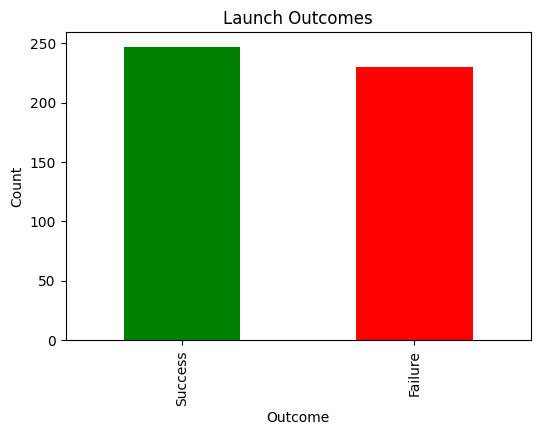

In [10]:
import matplotlib.pyplot as plt

# Normalize success/failure outcomes
df['outcome_clean'] = df['booster landing'].str.contains('Success', case=False, na=False).map({True: 'Success', False: 'Failure'})

# Plot outcome counts
df['outcome_clean'].value_counts().plot(kind='bar', figsize=(6,4), color=['green','red'])
plt.title('Launch Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()



🔹 Boxplot with Log Transformation - because of extreme large values of payload mass applying log

/tmp/ipython-input-2853932490.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


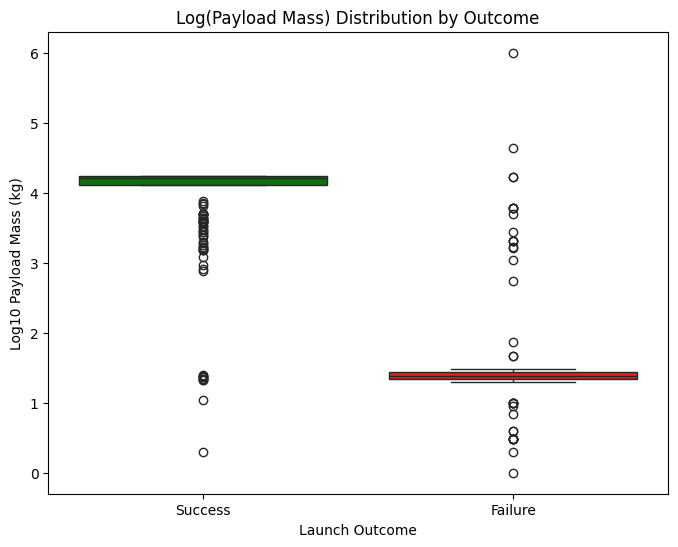

In [12]:
import numpy as np

plt.figure(figsize=(8,6))
sns.boxplot(
    x='outcome_clean',
    y=np.log10(df['payload_mass_kg_extracted']+1),   # +1 to avoid log(0)
    data=df,
    palette={'Success':'green','Failure':'red'}
)
plt.title('Log(Payload Mass) Distribution by Outcome')
plt.xlabel('Launch Outcome')
plt.ylabel('Log10 Payload Mass (kg)')
plt.show()


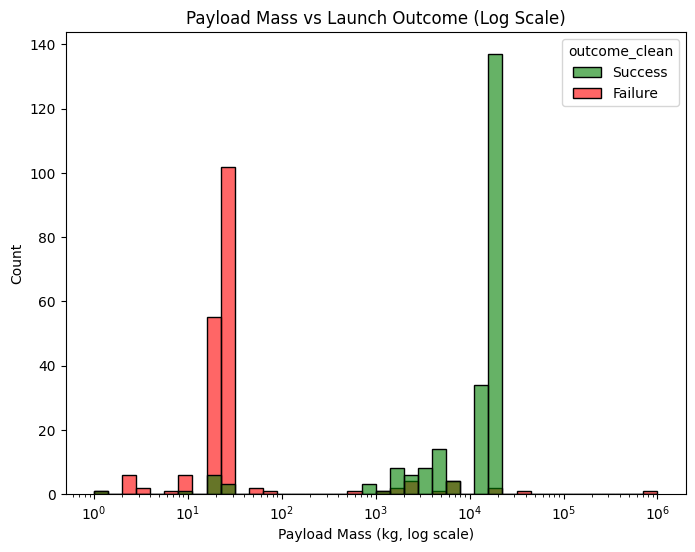

In [13]:
plt.figure(figsize=(8,6))
sns.histplot(
    data=df,
    x='payload_mass_kg_extracted',
    hue='outcome_clean',
    bins=40,
    log_scale=True,   # logarithmic x-axis
    palette={'Success':'green','Failure':'red'},
    alpha=0.6
)
plt.title('Payload Mass vs Launch Outcome (Log Scale)')
plt.xlabel('Payload Mass (kg, log scale)')
plt.ylabel('Count')
plt.show()


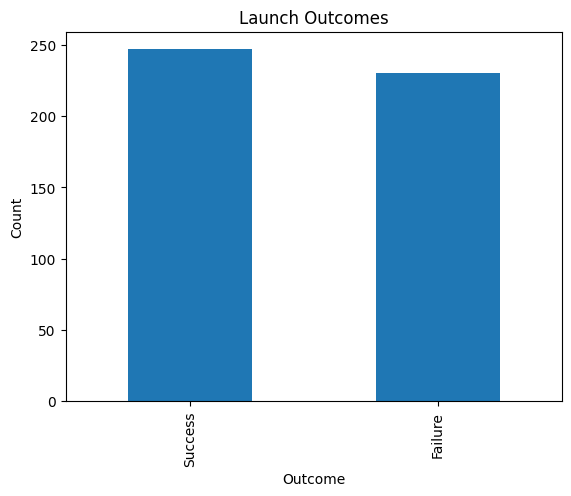

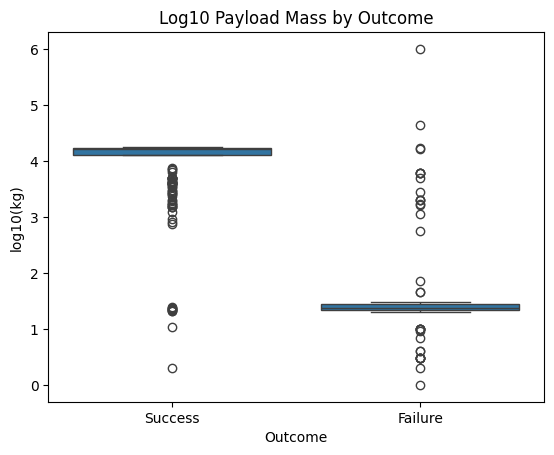

In [14]:
# Basic imports (if not already)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# If you're using the Wiki dataframe:
dfw = df.copy()  # assumes your cleaned wiki df is in `df`
dfw['outcome_clean'] = dfw['booster landing'].str.contains('Success', case=False, na=False).map({True:'Success', False:'Failure'})

# 3.1 Outcome count (matplotlib)
dfw['outcome_clean'].value_counts().plot(kind='bar')
plt.title('Launch Outcomes'); plt.xlabel('Outcome'); plt.ylabel('Count'); plt.show()

# 3.2 Payload vs outcome (seaborn, log scale)
sns.boxplot(x='outcome_clean', y=np.log10(dfw['payload_mass_kg_extracted']+1), data=dfw)
plt.title('Log10 Payload Mass by Outcome'); plt.xlabel('Outcome'); plt.ylabel('log10(kg)'); plt.show()

# 3.3 Success rate by orbit (plotly)
sr = dfw.groupby('orbit')['outcome_clean'].apply(lambda x: (x=='Success').mean()).reset_index(name='success_rate')
px.bar(sr, x='orbit', y='success_rate', title='Success Rate by Orbit').show()


# **4) SQL Queries for Structured Insights (ipython-sql)**

In [15]:
!pip install pandasql
# or
!pip install duckdb


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=cb3c8c9f52a2b0239e6cae6772f183ead7957e65526335f50d814fb9fbc1a440
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


# **Apply SQL queries for structured insights**

In [45]:
import pandas as pd

# Load dataset directly from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
df = pd.read_html(url, header=0)[2]   # usually the 3rd table holds the launch data

print(df.head())
print(df.shape)



   Flight No.                                Date and time (UTC)                                Version, booster[i]  \
0         418                         January 4, 2025 01:27[254]                                     F9 B5 B1073‑20   
1         418  Planned replacement for Thuraya 2 and 3.[255][...  Planned replacement for Thuraya 2 and 3.[255][...   
2         419                         January 6, 2025 20:43[257]                                     F9 B5 B1077‑17   
3         419  Launch of 24 Starlink v2 mini satellites to a ...  Launch of 24 Starlink v2 mini satellites to a ...   
4         420                         January 8, 2025 15:27[258]                                      F9 B5 B1086‑3   

                                         Launch site                                         Payload[j]                                       Payload mass  \
0                             Cape Canaveral, SLC‑40                                      Thuraya 4-NGS                        

In [20]:
import duckdb

duckdb.register('df', df)


In [46]:
query = """
SELECT orbit, COUNT(*) AS total,
       SUM(CASE WHEN "Launch outcome" LIKE '%Success%' THEN 1 ELSE 0 END) AS success_count,
       SUM(CASE WHEN "Launch outcome" LIKE '%Failure%' THEN 1 ELSE 0 END) AS failure_count
FROM df
GROUP BY orbit
ORDER BY total DESC;
"""

result = duckdb.sql(query).df()
print(result)


                                                Orbit  total  success_count  failure_count
0                                                 LEO     76           76.0            0.0
1                                                 SSO     12           12.0            0.0
2   Launch of 21 Starlink v2 mini satellites, incl...      7            0.0            0.0
3   Launch of 23 Starlink v2 mini satellites, incl...      7            0.0            0.0
4   Launch of 26 Starlink v2 mini optimized satell...      5            0.0            0.0
..                                                ...    ...            ...            ...
76  Launch of 24 satellites to expand internet con...      1            0.0            0.0
77  Long-duration mission. Will ferry four Expedit...      1            0.0            0.0
78  Launch of 24 Starlink v2 mini satellites to a ...      1            0.0            0.0
79  Launch of 24 Starlink v2 mini satellites to a ...      1            0.0            0.0

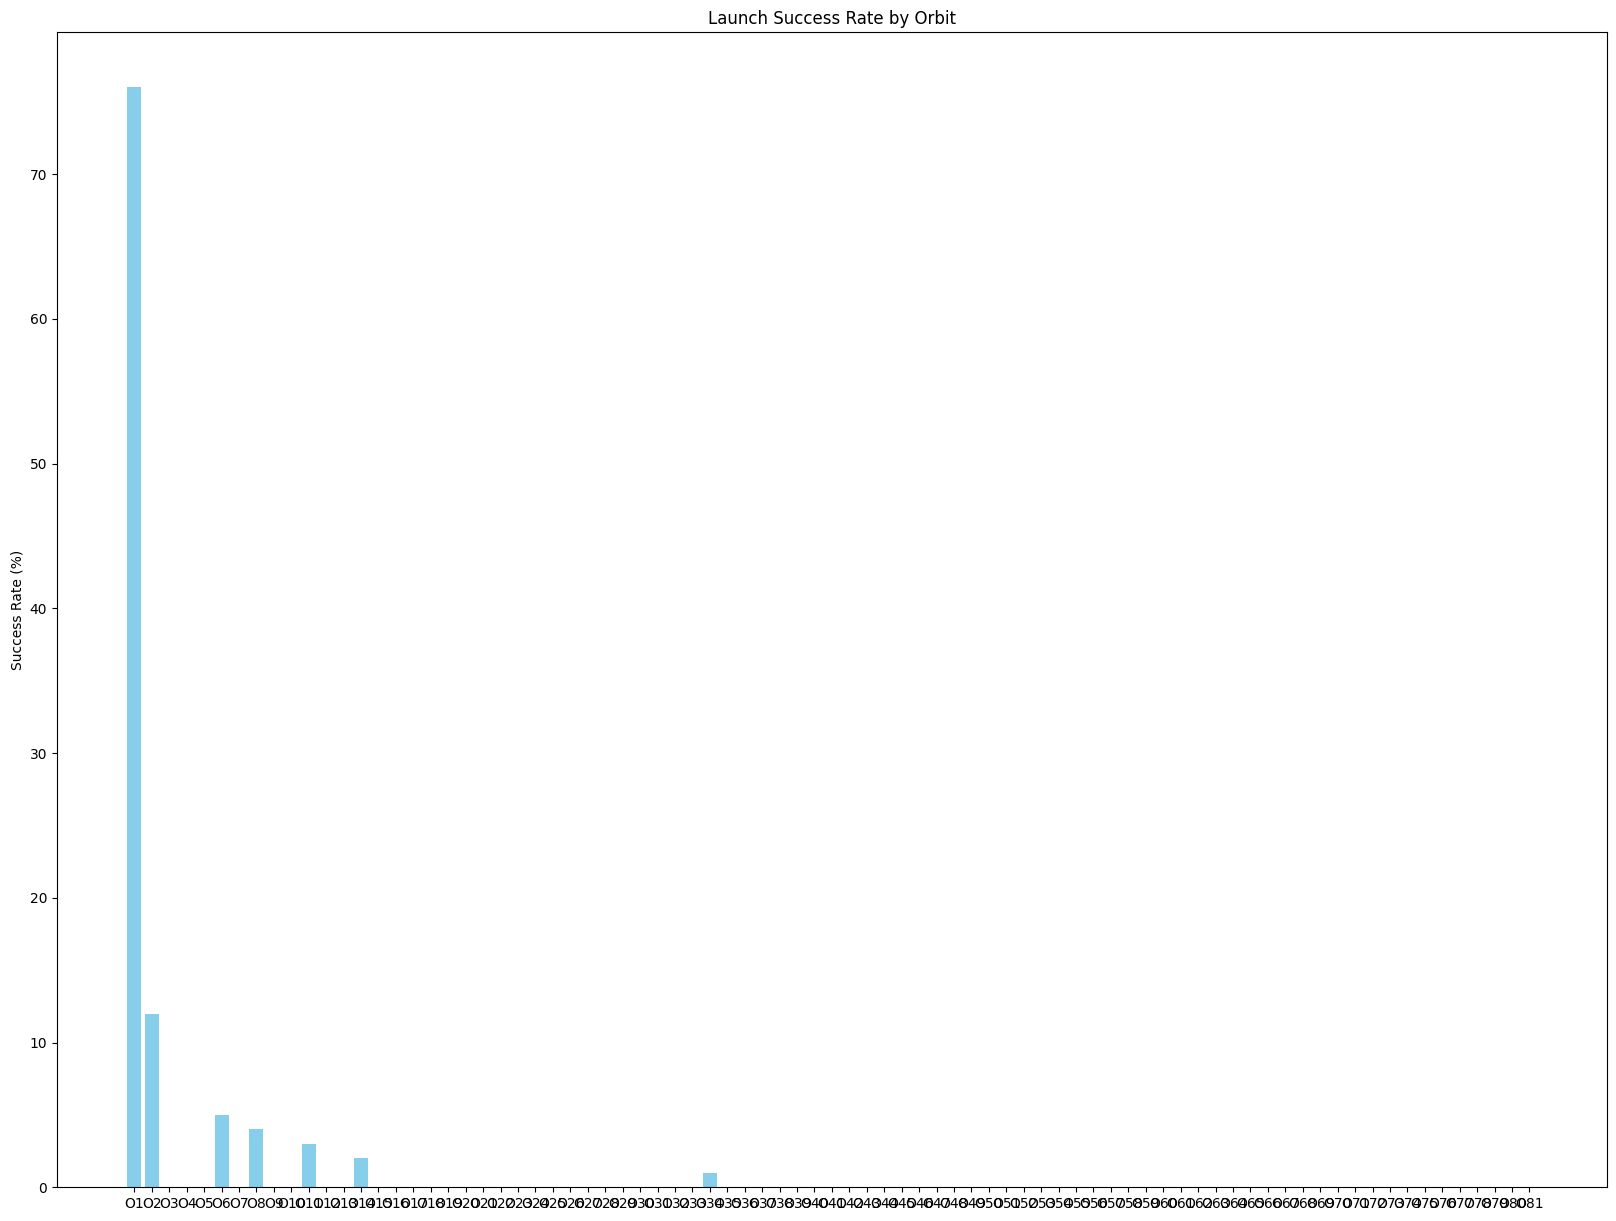

Legend (orbit keys):
O1 → LEO
O2 → SSO
O3 → Launch of 21 Starlink v2 mini satellites, including 13 with direct-to-cell connectivity, to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O4 → Launch of 23 Starlink v2 mini satellites, including 13 with direct-to-cell connectivity, to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O5 → Launch of 26 Starlink v2 mini optimized satellites to a 535 km (332 mi) orbit at an inclination of 70° to expand internet constellation.
O6 → GTO
O7 → Launch of 28 Starlink v2 mini optimized satellites to a 279 km (173 mi) orbit at an inclination of 53° to expand internet constellation.
O8 → LEO (ISS)
O9 → Launch of 27 Starlink v2 mini optimized satellites to a 535 km (332 mi) orbit at an inclination of 53° to expand internet constellation.
O10 → Launch of 28 Starlink v2 mini optimized satellites to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O11 → TL

In [47]:
import matplotlib.pyplot as plt

# Create mapping: orbit → short key
orbit_labels = result['Orbit'].tolist()
orbit_keys = {orbit: f"O{i+1}" for i, orbit in enumerate(orbit_labels)}

# Replace orbit with short keys for plotting
result['orbit_key'] = result['Orbit'].map(orbit_keys)

# Plot with short keys
plt.figure(figsize=(20,15))
plt.bar(result['orbit_key'], result['success_count'], color='skyblue')
plt.ylabel("Success Rate (%)")
plt.title("Launch Success Rate by Orbit")

# Rotate short keys (small, readable)
plt.xticks(rotation=0)

plt.show()

# Print mapping as legend
print("Legend (orbit keys):")
for k, v in orbit_keys.items():
    print(f"{v} → {k}")



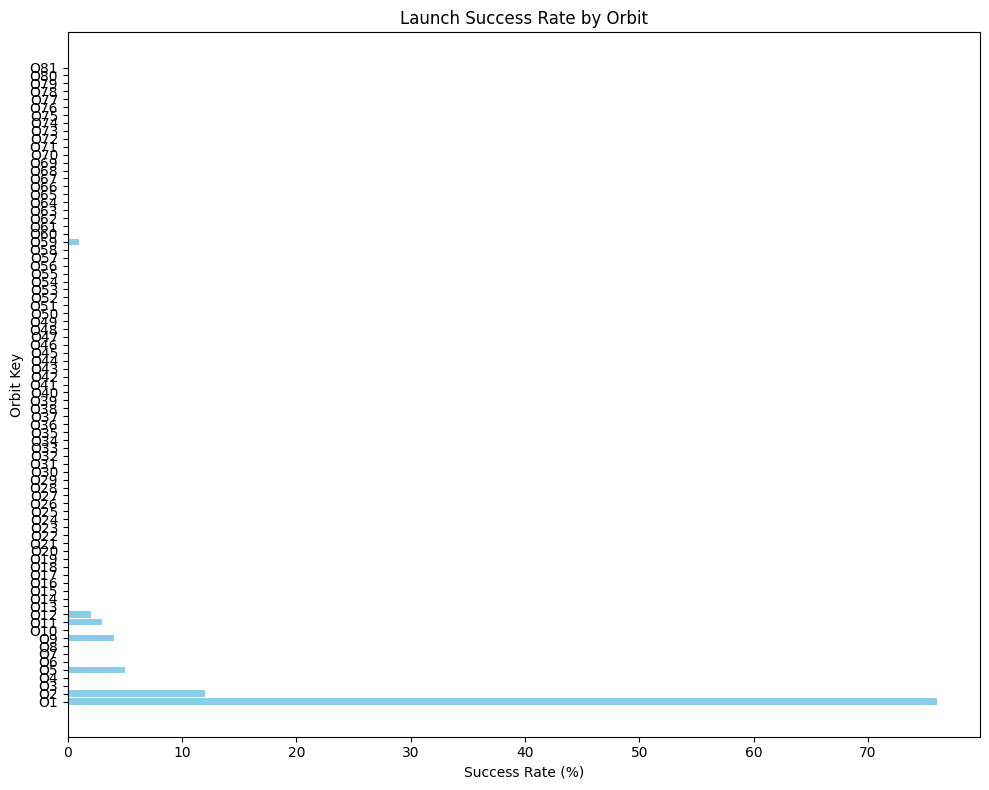

O1 → LEO
O2 → SSO
O3 → Launch of 21 Starlink v2 mini satellites, including 13 with direct-to-cell connectivity, to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O4 → Launch of 23 Starlink v2 mini satellites, including 13 with direct-to-cell connectivity, to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O5 → GTO
O6 → Launch of 28 Starlink v2 mini optimized satellites to a 279 km (173 mi) orbit at an inclination of 53° to expand internet constellation.
O7 → Launch of 26 Starlink v2 mini optimized satellites to a 535 km (332 mi) orbit at an inclination of 70° to expand internet constellation.
O8 → Launch of 28 Starlink v2 mini optimized satellites to a 559 km (347 mi) orbit at an inclination of 43° to expand internet constellation.
O9 → LEO (ISS)
O10 → Launch of 27 Starlink v2 mini optimized satellites to a 535 km (332 mi) orbit at an inclination of 53° to expand internet constellation.
O11 → TLI
O12 → MEO
O13 → Ded

In [29]:
plt.figure(figsize=(10,8))
plt.barh(result['orbit_key'], result['success_count'], color='skyblue')
plt.xlabel("Success Rate (%)")
plt.ylabel("Orbit Key")
plt.title("Launch Success Rate by Orbit")
plt.tight_layout()
plt.show()

# Legend mapping
for k, v in orbit_keys.items():
    print(f"{v} → {k}")


In [31]:
query = """
SELECT customer, COUNT(*) AS total_launches,
       ROUND(100.0 * SUM(CASE WHEN "Launch Outcome" LIKE '%Success%' THEN 1 ELSE 0 END) / COUNT(*), 2) AS success_rate
FROM df
GROUP BY customer
ORDER BY total_launches DESC;
"""
customers = duckdb.sql(query).df()
print(customers)


                                             Customer  total_launches  success_rate
0                                              SpaceX              73         100.0
1   Launch of 21 Starlink v2 mini satellites, incl...               7           0.0
2   Launch of 23 Starlink v2 mini satellites, incl...               7           0.0
3   Launch of 28 Starlink v2 mini optimized satell...               5           0.0
4   Launch of 26 Starlink v2 mini optimized satell...               5           0.0
..                                                ...             ...           ...
90  Launch of 24 satellites to expand internet con...               1           0.0
91  Long-duration mission. Will ferry four Expedit...               1           0.0
92  Launch of 24 Starlink v2 mini satellites to a ...               1           0.0
93  Launch of 24 Starlink v2 mini satellites to a ...               1           0.0
94  Launch of 24 Starlink v2 mini satellites to a ...               1       

In [ ]:
query = """
SELECT launch_site, COUNT(*) AS total_launches,
       ROUND(100.0 * SUM(CASE WHEN launch_outcome LIKE '%Success%' THEN 1 ELSE 0 END) / COUNT(*), 2) AS success_rate
FROM df
GROUP BY launch_site
ORDER BY total_launches DESC;
"""
sites = duckdb.sql(query).df()
print(sites)


In [74]:
# -----------------------------
# 2) DATA WRANGLING
# -----------------------------

# Reload saved data (ensures reproducibility if notebook restarted)
api_df = pd.read_csv(RAW_API_CSV)
wiki_df = pd.read_csv(RAW_WIKI_CSV)

print("API DF:", api_df.shape, " | WIKI DF:", wiki_df.shape)

# -----------------------------
# 2.1) Focus only on useful columns
# -----------------------------
keep_cols = [
    'flight_number','mission_name','year','rocket_name','launch_site_name',
    'success_launch','payload_mass_kg_mean','payload_mass_kg_sum',
    'primary_orbit','landing_attempt','first_stage_landing_success',
    'landing_type','core_flights_on_this_mission','core_total_flights_lifetime'
]

df = api_df[keep_cols].copy()

# -----------------------------
# 2.2) Handle missing values
# -----------------------------
print("Missingness before cleaning:\n", df.isna().mean().sort_values(ascending=False))

# Strategy:
# - Payload mass: fill NaNs with 0
# - Orbits: fill NaNs with 'Unknown'
# - Core flights: fill with 0
# - Target: drop rows with missing landing success (cannot train without labels)

df['payload_mass_kg_mean'] = df['payload_mass_kg_mean'].fillna(0)
df['payload_mass_kg_sum'] = df['payload_mass_kg_sum'].fillna(0)
df['primary_orbit'] = df['primary_orbit'].fillna('Unknown')
df['core_flights_on_this_mission'] = df['core_flights_on_this_mission'].fillna(0)
df['core_total_flights_lifetime'] = df['core_total_flights_lifetime'].fillna(0)

df = df.dropna(subset=['first_stage_landing_success'])  # keep only labeled

# Convert boolean target to int
df['first_stage_landing_success'] = df['first_stage_landing_success'].astype(int)

print("Cleaned shape:", df.shape)

# -----------------------------
# 2.3) Encode Categorical Variables
# -----------------------------
cat_features = ['rocket_name','launch_site_name','primary_orbit','landing_type']
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

print("Encoded shape:", df_encoded.shape)

# -----------------------------
# 2.4) Save Cleaned Data
# -----------------------------
CLEAN_CSV = os.path.join(DATA_DIR, "spacex_clean.csv")
df_encoded.to_csv(CLEAN_CSV, index=False)
print("✅ Clean dataset saved ->", CLEAN_CSV)

df_encoded.head()

API DF: (205, 24)  | WIKI DF: (477, 10)
Missingness before cleaning:
 core_total_flights_lifetime     1.000000
first_stage_landing_success     0.239024
landing_type                    0.229268
payload_mass_kg_mean            0.190244
payload_mass_kg_sum             0.190244
success_launch                  0.092683
landing_attempt                 0.087805
core_flights_on_this_mission    0.082927
primary_orbit                   0.063415
launch_site_name                0.000000
flight_number                   0.000000
rocket_name                     0.000000
year                            0.000000
mission_name                    0.000000
dtype: float64
Cleaned shape: (156, 14)
Encoded shape: (156, 27)
✅ Clean dataset saved -> data/spacex_clean.csv


,flight_number,mission_name,year,success_launch,payload_mass_kg_mean,payload_mass_kg_sum,landing_attempt,first_stage_landing_success,core_flights_on_this_mission,core_total_flights_lifetime,rocket_name_Falcon Heavy,launch_site_name_KSC LC 39A,launch_site_name_VAFB SLC 4E,primary_orbit_GEO,primary_orbit_GTO,primary_orbit_HCO,primary_orbit_HEO,primary_orbit_ISS,primary_orbit_LEO,primary_orbit_MEO,primary_orbit_PO,primary_orbit_SSO,primary_orbit_TLI,primary_orbit_Unknown,primary_orbit_VLEO,landing_type_Ocean,landing_type_RTLS
10,11,CASSIOPE,2013,True,500.0,500.0,True,0,1.0,0.0,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False
13,14,CRS-3,2014,True,2296.0,2296.0,True,1,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
14,15,OG-2 Mission 1,2014,True,1316.0,1316.0,True,1,1.0,0.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
17,18,CRS-4,2014,True,2216.0,2216.0,True,0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
18,19,CRS-5,2015,True,2395.0,2395.0,True,0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


# **Q1. How do payload mass, launch site, number of flights, and orbits affect first stage landing success?**

In [56]:
df.groupby("launch_site_name")["first_stage_landing_success"].mean()


,first_stage_landing_success
launch_site_name,
CCSFS SLC 40,0.900000
KSC LC 39A,0.941176
VAFB SLC 4E,0.920000


# **Q2. Does the rate of successful landings increase over the years?**

👉 Using year and first_stage_landing_success.

📊 Steps:

Group by year, calculate landing success rate.

Plot trend over time.

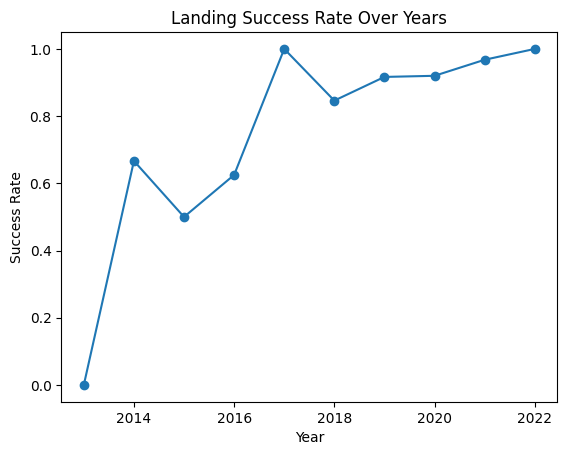

In [57]:
yearly_trend = df.groupby("year")["first_stage_landing_success"].mean().reset_index()

import matplotlib.pyplot as plt
plt.plot(yearly_trend["year"], yearly_trend["first_stage_landing_success"], marker="o")
plt.title("Landing Success Rate Over Years")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.show()


# **Q3. What is the best algorithm for binary classification?**

👉 Target: first_stage_landing_success
👉 Predictors: payload mass, orbits, launch site, flight counts, etc.

📊 Pipeline:

Preprocess data:

Encode categorical variables (launch_site_name, primary_orbit, landing_type).

Scale numeric variables.

Train/Test Split.

Models to try:

Logistic Regression

Decision Tree

Random Forest

Support Vector Machine (SVM)

Evaluate with:

Accuracy

Precision, Recall, F1-score

Confusion Matrix

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression    0.9375   0.937500  1.000000  0.967742
1        Decision Tree    0.8750   0.933333  0.933333  0.933333
2        Random Forest    0.9375   0.937500  1.000000  0.967742
3                  SVM    0.9375   0.937500  1.000000  0.967742


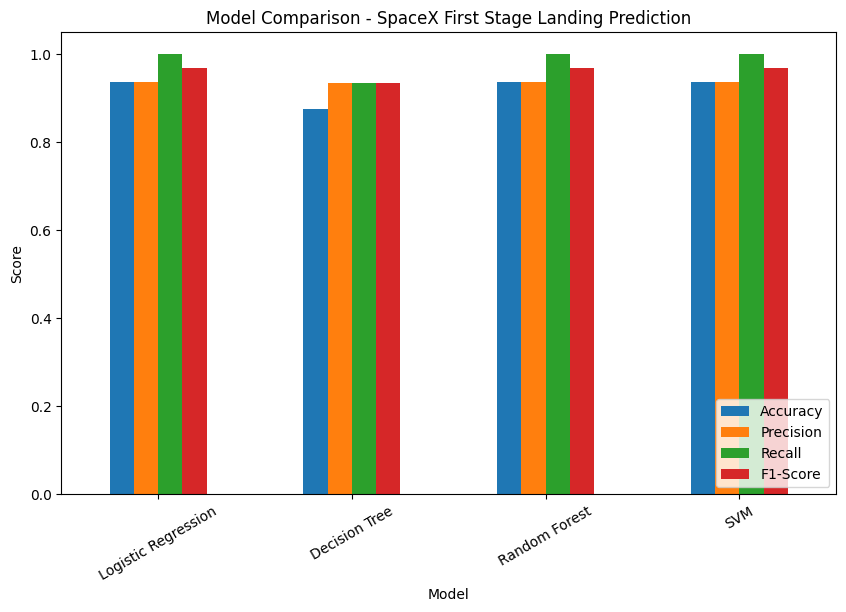

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Encode only launch_site_name and primary_orbit (label encode for simplicity)
label_enc = LabelEncoder()
df['launch_site_name'] = label_enc.fit_transform(df['launch_site_name'])
df['primary_orbit'] = label_enc.fit_transform(df['primary_orbit'])

# Features / Target
X = df[['payload_mass_kg_mean','payload_mass_kg_sum',
        'launch_site_name','primary_orbit','landing_type',
        'core_flights_on_this_mission','core_total_flights_lifetime']]
y = df['first_stage_landing_success']



# Separate numeric and categorical
numeric_features = ['payload_mass_kg_mean','payload_mass_kg_sum',
                    'core_flights_on_this_mission','core_total_flights_lifetime']
categorical_features = ['launch_site_name','primary_orbit','landing_type']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)



models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
# Train & Evaluate with Pipeline
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)


    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

# -------------------------------
# 4) Plot Comparison
# -------------------------------
results_df.set_index("Model", inplace=True)
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison - SpaceX First Stage Landing Prediction")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.legend(loc="lower right")
plt.show()




# **MODEL PERFORMANCE ,RESULTS AND PREDICTIONS:**

builds clean train/test pipelines (with scaling + one-hot encoding)

trains LogReg, Decision Tree, Random Forest, SVM

plots confusion matrices (all 4 in a grid)

plots one combined ROC curve (with AUC)

plots one combined Precision–Recall curve

shows a bar chart comparing Accuracy, Precision, Recall, F1

Model metrics:
                  Model  Accuracy  Precision    Recall  F1-Score
3                  SVM   0.90625   0.906250  1.000000  0.950820
0  Logistic Regression   0.87500   0.903226  0.965517  0.933333
2        Random Forest   0.87500   0.931034  0.931034  0.931034
1        Decision Tree   0.87500   0.962963  0.896552  0.928571


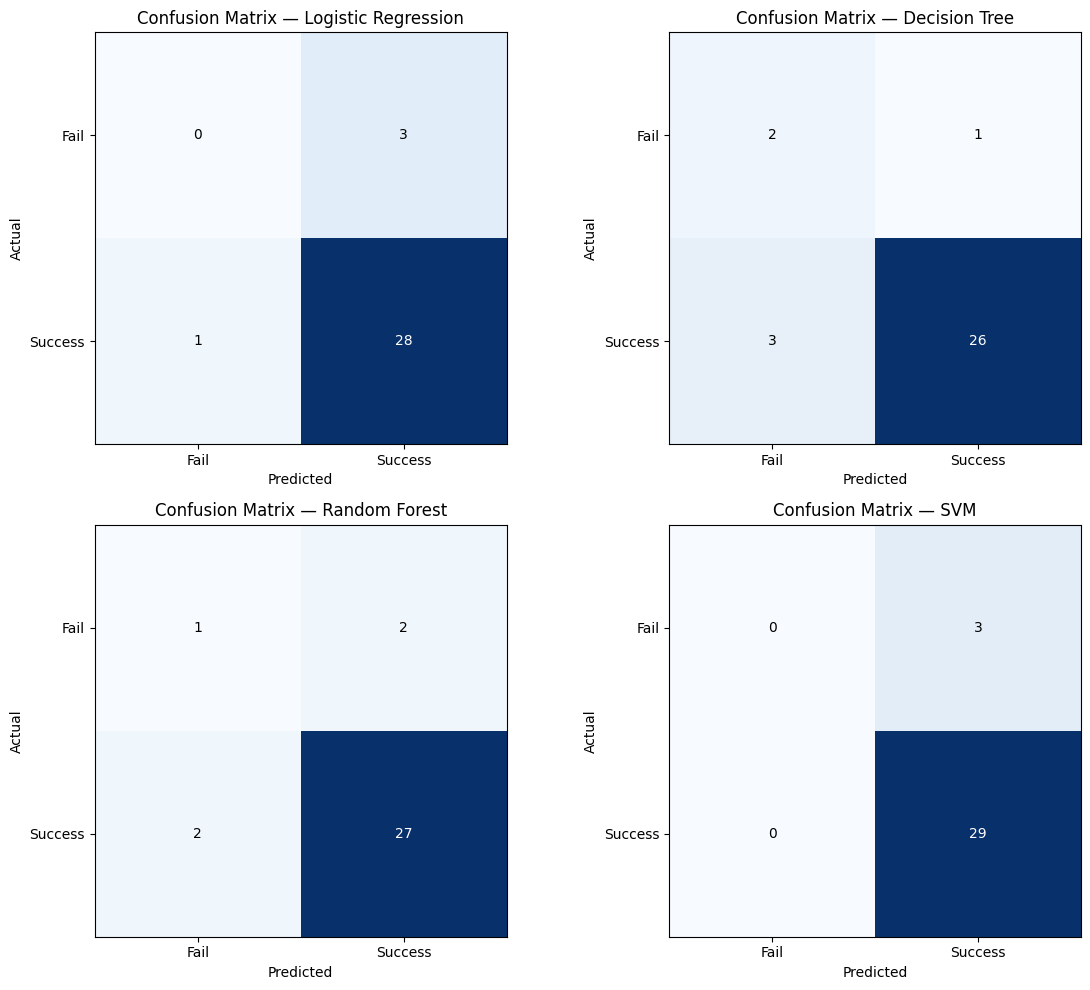

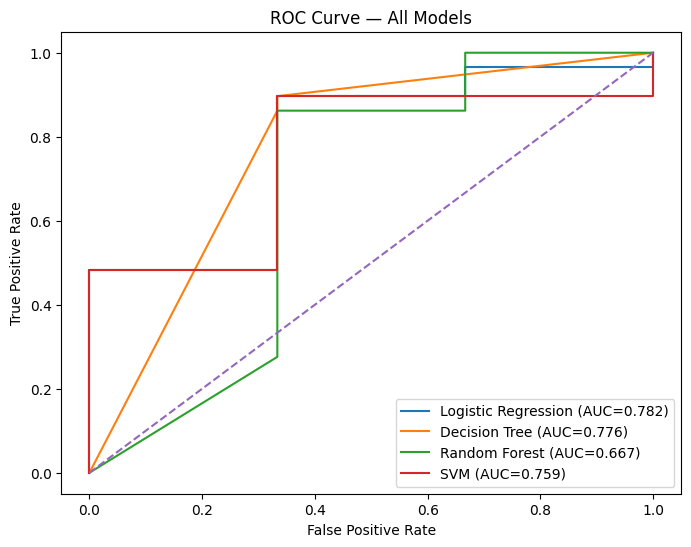

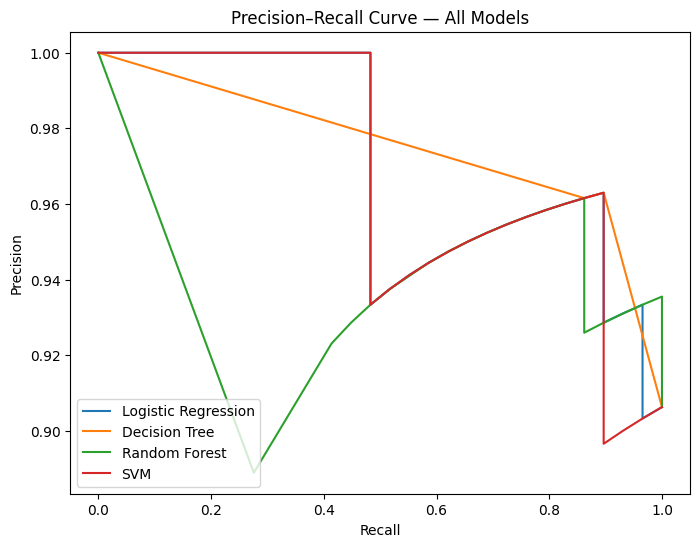

<Figure size 1000x600 with 0 Axes>

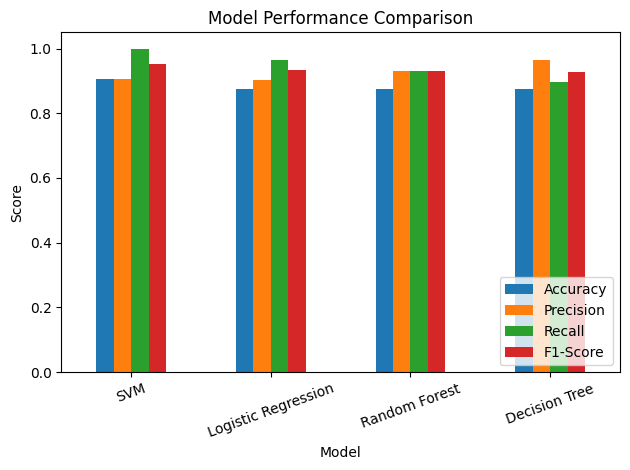


Best model: SVM  |  F1=0.951  (Acc=0.906, Prec=0.906, Rec=1.000)


In [112]:
# ============================
# SpaceX: Model Training + Plots (CM, ROC, PR, Metrics)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ----------------------------
# 1) Select features / target from your merged/cleaned df
# ----------------------------
# Assumes you already have: df with these columns present
feature_cols = [
    'payload_mass_kg_mean','payload_mass_kg_sum',
    'launch_site_name','primary_orbit','landing_type',
    'core_flights_on_this_mission','core_total_flights_lifetime','year'
]
target_col = 'first_stage_landing_success'  # 0/1

use_df = df[feature_cols + [target_col]].copy()
use_df = use_df.dropna(subset=[target_col])  # ensure target present
# (Optional) fill numeric missing with median; categorical with "Unknown"
num_cols = ['payload_mass_kg_mean','payload_mass_kg_sum',
            'core_flights_on_this_mission','core_total_flights_lifetime','year']
cat_cols = ['launch_site_name','primary_orbit','landing_type']

for c in num_cols:
    if c in use_df.columns:
        use_df[c] = use_df[c].astype(float)
        use_df[c] = use_df[c].fillna(use_df[c].median())

for c in cat_cols:
    if c in use_df.columns:
        use_df[c] = use_df[c].astype(str).fillna("Unknown")

X = use_df[feature_cols]
y = use_df[target_col].astype(int)

# ----------------------------
# 2) Train/test split (stratified)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ----------------------------
# 3) Preprocessor
# ----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

# ----------------------------
# 4) Define models (SVC with probability=True for ROC/PR)
# ----------------------------
candidates = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Build pipelines
pipelines = {
    name: Pipeline(steps=[('prep', preprocessor), ('clf', model)])
    for name, model in candidates.items()
}

# ----------------------------
# 5) Fit, Predict, Collect Metrics
# ----------------------------
metrics_rows = []
y_pred_dict = {}
y_proba_dict = {}
fitted = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    y_pred = pipe.predict(X_test)
    # Some models may not have predict_proba (we set SVC to have it)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    y_pred_dict[name] = y_pred
    y_proba_dict[name] = y_proba

    metrics_rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(metrics_rows).sort_values("F1-Score", ascending=False)
print("Model metrics:\n", results_df)

# ----------------------------
# 6) Confusion Matrices (2x2 grid)
# ----------------------------
fig_cm, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
labels = ["Fail", "Success"]

for ax, (name, y_pred) in zip(axes, y_pred_dict.items()):
    cm = confusion_matrix(y_test, y_pred)
    im = ax.imshow(cm, interpolation='nearest',cmap="Blues")
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xticks([0,1]); ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks([0,1]); ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

    # annotate cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

fig_cm.tight_layout()
plt.show()

# ----------------------------
# 7) Combined ROC Curves (all models on one plot)
# ----------------------------
plt.figure(figsize=(8,6))
for name, y_proba in y_proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — All Models")
plt.legend(loc="lower right")
plt.show()

# ----------------------------
# 8) Combined Precision–Recall Curves
# ----------------------------
plt.figure(figsize=(8,6))
for name, y_proba in y_proba_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — All Models")
plt.legend(loc="lower left")
plt.show()

# ----------------------------
# 9) Bar chart — Accuracy/Precision/Recall/F1
# ----------------------------
plt.figure(figsize=(10,6))
plot_df = results_df.set_index("Model")[["Accuracy","Precision","Recall","F1-Score"]]
plot_df.plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ----------------------------
# 10) (Optional) Print best model
# ----------------------------
best_row = results_df.iloc[0]
print(f"\nBest model: {best_row['Model']}  |  F1={best_row['F1-Score']:.3f}  "
      f"(Acc={best_row['Accuracy']:.3f}, Prec={best_row['Precision']:.3f}, Rec={best_row['Recall']:.3f})")


                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.9375     0.9375     1.0  0.967742
1        Decision Tree    0.9375     0.9375     1.0  0.967742
2        Random Forest    0.9375     0.9375     1.0  0.967742
3                  SVM    0.9375     0.9375     1.0  0.967742


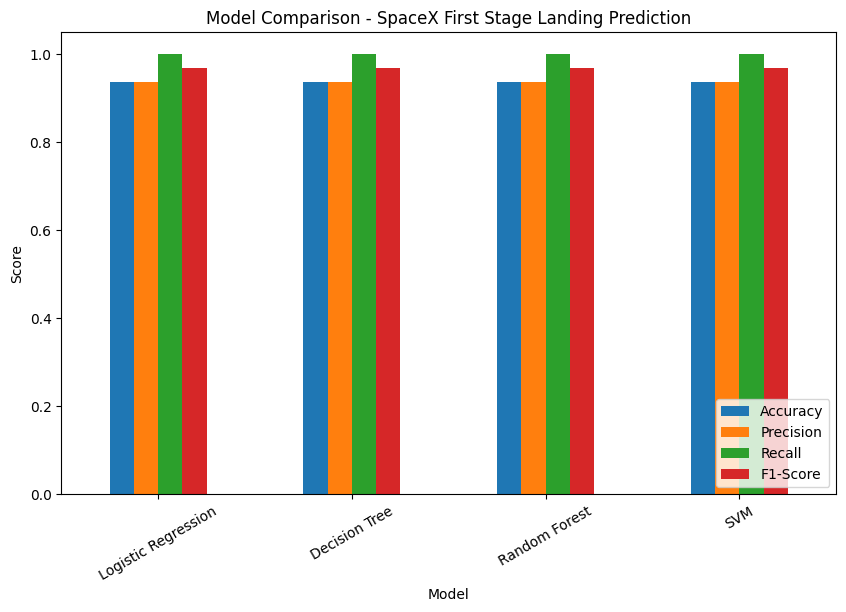

                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.9375     0.9375     1.0  0.967742
Decision Tree          0.9375     0.9375     1.0  0.967742
Random Forest          0.9375     0.9375     1.0  0.967742
SVM                    0.9375     0.9375     1.0  0.967742


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# -------------------------------
# 1) Prepare Data
# -------------------------------
df = df[[
    'payload_mass_kg_mean','launch_site_name','primary_orbit',
    'core_total_flights_lifetime','year','first_stage_landing_success'
]].dropna()

# Encode categorical vars
label_enc = LabelEncoder()
df['launch_site_name'] = label_enc.fit_transform(df['launch_site_name'])
df['primary_orbit'] = label_enc.fit_transform(df['primary_orbit'])

X = df.drop('first_stage_landing_success', axis=1)
y = df['first_stage_landing_success']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -------------------------------
# 2) Define Models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []

# -------------------------------
# 3) Train & Evaluate
# -------------------------------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

# -------------------------------
# 4) Plot Comparison
# -------------------------------
results_df.set_index("Model", inplace=True)
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison - SpaceX First Stage Landing Prediction")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.legend(loc="lower right")
plt.show()

print(results_df)


# **📊 2. Interactive Dashboards using Plotly Dash**

Dash apps are more like mini websites. Here’s a minimal app for success rate by orbit:

In [33]:
# Mapping launch sites to coordinates
site_coords = {
    "CCAFS LC-40": [28.562302, -80.577356],
    "CCAFS SLC-40": [28.561857, -80.577366],
    "KSC LC-39A": [28.573255, -80.646895],
    "VAFB SLC-4E": [34.632093, -120.610829]
}

# Add Latitude & Longitude columns
df["Latitude"] = df["Launch site"].map(lambda x: site_coords.get(x, [None, None])[0])
df["Longitude"] = df["Launch site"].map(lambda x: site_coords.get(x, [None, None])[1])


# **🌍 Folium map**

In [34]:
import folium
from IPython.display import display

# Center map
m = folium.Map(location=[28.5, -80.6], zoom_start=5)

# Add markers
for _, row in df.iterrows():
    if pd.notna(row['Latitude']):
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Site: {row['launch_site']}<br>Customer: {row['customer']}",
            icon=folium.Icon(color="blue", icon="rocket", prefix='fa')
        ).add_to(m)

# Option 1: Show inline
display(m)

# Option 2: Save to HTML file
m.save("launch_sites_map.html")
print("✅ Map saved as 'launch_sites_map.html'. Open it to view markers.")


✅ Map saved as 'launch_sites_map.html'. Open it to view markers.


# **🌍 Folium map with Geo Locator**

In [36]:
!pip install geopy folium
from geopy.geocoders import Nominatim
import folium
import pandas as pd
from IPython.display import display

# Make sure your df is loaded
launch_sites = df['Launch site'].unique()

# Initialize geolocator
geolocator = Nominatim(user_agent="spacex_mapper")

coords = {}
for site in launch_sites:
    try:
        location = geolocator.geocode(site)
        if location:
            coords[site] = [location.latitude, location.longitude]
    except:
        coords[site] = [None, None]

# Add coordinates to df
df['Latitude'] = df['Launch site'].map(lambda x: coords.get(x, [None, None])[0])
df['Longitude'] = df['Launch site'].map(lambda x: coords.get(x, [None, None])[1])


#ASSIGNING LATITUTE/LONGITUDE VALUES MANUALLY TO SEE SOME OF THE LAUNCH-SITE

In [37]:
import folium
from IPython.display import display

# Define known coordinates for SpaceX launch sites
site_coords = {
    "CCAFS LC-40": [28.5618571, -80.577366],
    "KSC LC-39A": [28.573255, -80.646895],
    "VAFB SLC-4E": [34.632834, -120.610746],
    "CCAFS SLC-40": [28.563197, -80.576820]
}

# Create base map (centered around Florida first)
m = folium.Map(location=[28.5, -80.5], zoom_start=4)

# Add markers for all locations in your table
for site, coords in site_coords.items():
    folium.Marker(
        location=coords,
        popup=f"<b>{site}</b>",
        icon=folium.Icon(color="red", icon="rocket")
    ).add_to(m)

# Show in notebook
display(m)

# Save as HTML file for interactive viewing
m.save("spacex_launch_sites.html")
print("✅ Map saved as 'spacex_launch_sites.html'")


✅ Map saved as 'spacex_launch_sites.html'


# **Plotly Dash for interactive dashboards**

In [38]:
!pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Example dataset (replace with your SpaceX dataframe)
data = {
    "Launch Site": ["CCAFS LC-40", "KSC LC-39A", "VAFB SLC-4E", "CCAFS LC-40", "KSC LC-39A"],
    "Outcome": ["Success", "Success", "Failure", "Failure", "Success"]
}
df = pd.DataFrame(data)

# Coordinates for launch sites
site_coords = {
    "CCAFS LC-40": [28.5618571, -80.577366],
    "KSC LC-39A": [28.573255, -80.646895],
    "VAFB SLC-4E": [34.632834, -120.610746]
}
coords_df = pd.DataFrame([
    {"Launch Site": site, "Latitude": lat, "Longitude": lon}
    for site, (lat, lon) in site_coords.items()
])

# Merge coordinates into dataframe
df = df.merge(coords_df, on="Launch Site", how="left")

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("🚀 SpaceX Launch Dashboard", style={"textAlign": "center"}),

    # Dropdown for site selection
    dcc.Dropdown(
        id="site-dropdown",
        options=[{"label": site, "value": site} for site in df["Launch Site"].unique()] + [{"label": "All Sites", "value": "ALL"}],
        value="ALL",
        placeholder="Select a Launch Site"
    ),

    # Bar chart for outcomes
    dcc.Graph(id="outcome-bar"),

    # Map for locations
    dcc.Graph(id="launch-map")
])

# Callback to update charts
@app.callback(
    [Output("outcome-bar", "figure"),
     Output("launch-map", "figure")],
    [Input("site-dropdown", "value")]
)
def update_dashboard(selected_site):
    if selected_site == "ALL":
        filtered_df = df
    else:
        filtered_df = df[df["Launch Site"] == selected_site]

    # Bar chart
    bar_fig = px.histogram(
        filtered_df,
        x="Outcome",
        color="Outcome",
        title=f"Launch Outcomes for {selected_site}" if selected_site != "ALL" else "Launch Outcomes for All Sites"
    )

    # Map chart
    map_fig = px.scatter_mapbox(
        df if selected_site == "ALL" else filtered_df,
        lat="Latitude",
        lon="Longitude",
        color="Launch Site",
        hover_name="Launch Site",
        zoom=3,
        height=500
    )
    map_fig.update_layout(mapbox_style="open-street-map")

    return bar_fig, map_fig


if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)


<IPython.core.display.Javascript object>